In [2]:
import os
import sys
import time
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, ReduceLROnPlateau

from transformers import CLIPProcessor, CLIPModel
from datasets import load_dataset, DatasetDict
from sklearn.metrics import accuracy_score, top_k_accuracy_score
from tqdm import tqdm


# Load pretrained CLIP
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").cuda()
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


/home/sysadm/Music/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [21]:
!rm -rf ~/.cache/huggingface/datasets


In [22]:
# from datasets import load_dataset
# # ds = load_dataset("eltorio/ROCO-radiology")
# ds = load_dataset("eltorio/ROCO-radiology", download_mode="force_redownload")

In [23]:
from datasets import load_dataset

# Load 80% from each of the train, validation, and test splits
train_ds = load_dataset("eltorio/ROCO-radiology", split="train[:80%]")
val_ds = load_dataset("eltorio/ROCO-radiology", split="validation[:80%]")
test_ds = load_dataset("eltorio/ROCO-radiology", split="test[:80%]")

def is_valid(example):
    return example.get("image") is not None and example.get("caption") and example["caption"].strip() != ""

train_ds = train_ds.filter(is_valid)
val_ds = val_ds.filter(is_valid)
test_ds = test_ds.filter(is_valid)

# Save to disk
train_ds.save_to_disk("roco_train_80")
val_ds.save_to_disk("roco_val_80")
test_ds.save_to_disk("roco_test_80")

Saving the dataset (1/1 shards): 100%|██████████| 6541/6541 [00:01<00:00, 3421.12 examples/s]


In [24]:
from datasets import load_from_disk

# Load the datasets back
train_ds = load_from_disk("roco_train_80")
val_ds = load_from_disk("roco_val_80")
test_ds = load_from_disk("roco_test_80")


In [25]:
train_ds

Dataset({
    features: ['image', 'image_id', 'caption'],
    num_rows: 52337
})

In [26]:
val_ds

Dataset({
    features: ['image', 'image_id', 'caption'],
    num_rows: 6540
})

In [27]:
test_ds

Dataset({
    features: ['image', 'image_id', 'caption'],
    num_rows: 6541
})

In [28]:
train_ds

Dataset({
    features: ['image', 'image_id', 'caption'],
    num_rows: 52337
})

In [ ]:
# # Shuffle and sample 10% from each split
# train_ds = train_ds.shuffle(seed=42).select(range(int(0.1 * len(train_ds))))
# val_ds = val_ds.shuffle(seed=42).select(range(int(0.1 * len(val_ds))))
# test_ds = test_ds.shuffle(seed=42).select(range(int(0.1 * len(test_ds))))

In [29]:
print(f"Train dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")
print(f"Test dataset size: {len(test_ds)}")

Train dataset size: 52337
Validation dataset size: 6540
Test dataset size: 6541


In [30]:

from torch.utils.data import Dataset

class RocoDataset(Dataset):
    """
    A minimal wrapper that returns dicts with keys:
        image • text
    ready for a CLIP/BLIP-style processor.
    """
    def __init__(self, hf_dataset, strip_caption=True):
        # (optional) drop items with empty captions and trim whitespace
        if strip_caption:
            hf_dataset = hf_dataset.map(
                lambda x: {"caption": x["caption"].strip() if x["caption"] else None}
            )
        hf_dataset = hf_dataset.filter(
            lambda x: x["caption"] is not None and x["caption"].strip() != ""
        )

        self.dataset = hf_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        return {
            "image": item["image"],               # PIL.Image
            "text":  item["caption"]              # str
        }

def collate_fn(batch, processor):
    """
    Turns a list of {'image': PIL, 'text': str} dicts
    into the tensor batch expected by CLIP/BLIP.
    """
    images = [b["image"] for b in batch]
    texts  = [b["text"]  for b in batch]

    # processor returns a dict with keys:
    #   pixel_values • input_ids • attention_mask  (and possibly token_type_ids)
    return processor(
        text=texts,
        images=images,
        return_tensors="pt",
        padding=True,
        truncation=True,
    )



In [ ]:
# def do_train(model, train_loader, optimizer, epoch, device, scheduler=None, max_grad_norm=1.0, log_interval=10):
#     model.train()
#     total_loss = 0.0
#     start_time = time.time()

#     progress_bar = tqdm(train_loader, desc=f"Epoch {epoch} Training")

#     for batch_idx, batch in enumerate(progress_bar):
#         # Move batch to device
#         batch = {k: v.to(device) for k, v in batch.items()}

#         # Extract features
#         image_features = model.get_image_features(pixel_values=batch['pixel_values'])
#         text_features = model.get_text_features(
#             input_ids=batch['input_ids'],
#             attention_mask=batch.get('attention_mask', None)
#         )

#         # Normalize
#         image_features = F.normalize(image_features, dim=-1)
#         text_features = F.normalize(text_features, dim=-1)

#         # Compute logits
#         logit_scale = model.logit_scale.exp()
#         logits_per_image = logit_scale * image_features @ text_features.T
#         logits_per_text = logits_per_image.T

#         # Compute contrastive loss
#         batch_size = image_features.size(0)
#         labels = torch.arange(batch_size, device=device)
#         loss_i2t = F.cross_entropy(logits_per_image, labels)
#         loss_t2i = F.cross_entropy(logits_per_text, labels)
#         loss = (loss_i2t + loss_t2i) / 2

#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         if max_grad_norm > 0:
#             clip_grad_norm_(model.parameters(), max_grad_norm)
#         optimizer.step()

#         total_loss += loss.item()
#         progress_bar.set_postfix({"loss": loss.item()})

#         # Logging
#         if batch_idx % log_interval == 0:
#             current_lr = optimizer.param_groups[0]['lr']
#             print(f"Epoch {epoch} [{batch_idx}/{len(train_loader)}] Loss: {loss.item():.4f}, LR: {current_lr:.6f}")

#     if scheduler is not None:
#         scheduler.step()

#     train_time = time.time() - start_time
#     avg_train_loss = total_loss / len(train_loader)
#     print(f"Epoch {epoch}: Avg Loss: {avg_train_loss:.4f}, Time: {train_time:.2f}s")

#     return avg_train_loss, train_time



# @torch.no_grad()
# def do_eval(model, val_loader, device):
#     model.eval()
#     total_loss = 0.0
#     all_image_to_text_preds, all_image_to_text_labels = [], []
#     all_text_to_image_preds, all_text_to_image_labels = [], []
#     all_logits_per_image, all_logits_per_text = [], []
#     start_time = time.time()

#     for batch in val_loader:
#         batch = {k: v.to(device) for k, v in batch.items()}

#         # Forward pass for loss
#         outputs = model(**batch, return_loss=True)
#         total_loss += outputs.loss.item()

#         # Extract features
#         image_embeds = model.get_image_features(pixel_values=batch['pixel_values'])
#         text_embeds = model.get_text_features(
#             input_ids=batch['input_ids'],
#             attention_mask=batch.get('attention_mask', None)
#         )

#         # Normalize
#         image_embeds = F.normalize(image_embeds, dim=-1)
#         text_embeds = F.normalize(text_embeds, dim=-1)

#         # Compute similarities
#         logit_scale = model.logit_scale.exp()
#         logits_per_image = logit_scale * image_embeds @ text_embeds.T
#         logits_per_text = logits_per_image.T

#         # Get top-1 predictions
#         labels = torch.arange(logits_per_image.size(0), device=device)
#         image_to_text_preds = torch.argmax(logits_per_image, dim=1)
#         text_to_image_preds = torch.argmax(logits_per_text, dim=1)

#         all_image_to_text_preds.extend(image_to_text_preds.cpu().tolist())
#         all_image_to_text_labels.extend(labels.cpu().tolist())
#         all_text_to_image_preds.extend(text_to_image_preds.cpu().tolist())
#         all_text_to_image_labels.extend(labels.cpu().tolist())

#         # For top-k metrics
#         all_logits_per_image.append(logits_per_image.cpu())
#         all_logits_per_text.append(logits_per_text.cpu())

#     val_time = time.time() - start_time
#     avg_val_loss = total_loss / len(val_loader)

#     # Accuracy
#     image_to_text_acc = accuracy_score(all_image_to_text_labels, all_image_to_text_preds)
#     text_to_image_acc = accuracy_score(all_text_to_image_labels, all_text_to_image_preds)

#     # Top-5 Accuracy
#     top5_image_scores, top5_text_scores = [], []
#     for logits_img, logits_txt in zip(all_logits_per_image, all_logits_per_text):
#         batch_size = logits_img.shape[0]
#         k = min(5, batch_size)
#         labels = list(range(batch_size))
#         top5_image_scores.append(top_k_accuracy_score(labels, logits_img.numpy(), k=k, labels=labels))
#         top5_text_scores.append(top_k_accuracy_score(labels, logits_txt.numpy(), k=k, labels=labels))

#     image_to_text_top5 = sum(top5_image_scores) / len(top5_image_scores) if top5_image_scores else 0
#     text_to_image_top5 = sum(top5_text_scores) / len(top5_text_scores) if top5_text_scores else 0

#     # Summary
#     print(f"Validation Results:")
#     print(f"  Loss: {avg_val_loss:.4f}")
#     print(f"  Image→Text Accuracy: {image_to_text_acc:.4f} (Top-5: {image_to_text_top5:.4f})")
#     print(f"  Text→Image Accuracy: {text_to_image_acc:.4f} (Top-5: {text_to_image_top5:.4f})")

#     return {
#         "avg_val_loss": avg_val_loss,
#         "image_to_text_acc": image_to_text_acc,
#         "text_to_image_acc": text_to_image_acc,
#         "image_to_text_top5": image_to_text_top5,
#         "text_to_image_top5": text_to_image_top5,
#         "val_time": val_time
#     }



In [32]:
val_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x346>,
 'image_id': 'ROCO_00020',
 'caption': ' Axial computed tomography scan of the pelvis showing a diffuse infiltration of the bladder wall, catheter in situ (arrow).\n'}

In [33]:
custom_collate = lambda batch: collate_fn(batch, processor)


In [34]:
# DataLoader
from functools import partial

train_dataset = RocoDataset(train_ds)
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,num_workers=4, collate_fn=collate_fn)
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=custom_collate,  # pass processor here
    num_workers=4,
)
# Validation DataLoader
val_dataset = RocoDataset(val_ds)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate,num_workers=4,)  # pass processor here
# Test DataLoader
test_dataset = RocoDataset(test_ds)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False,collate_fn=custom_collate,num_workers=4,)  # pass processor here
optimizer = AdamW(model.parameters(), lr=1e-5)

Filter: 100%|██████████| 6541/6541 [00:07<00:00, 859.27 examples/s]


In [41]:
# import pandas as pd
# import torch

# # DataFrame to store metrics
# metrics_df = pd.DataFrame(columns=[
#     "epoch", "train_loss", "val_loss",
#     "image_to_text_acc", "text_to_image_acc",
#     "image_to_text_top5", "text_to_image_top5",
#     "train_time", "val_time"
# ])
# # scheduler = LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=3)
# scheduler = CosineAnnealingLR(optimizer, T_max=3, eta_min=1e-6)
# # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True)    

# EPOCHS = 5
# best_acc = 0.0
# best_model_path = "roco_clip_best_model.pt"

# for epoch in range(EPOCHS):
#     print(f"\n🚀 Epoch {epoch+1}/{EPOCHS}")

#     avg_train_loss, train_time = do_train(
#         model=model,
#         train_loader=train_loader,
#         optimizer=optimizer,
#         epoch=epoch+1,
#         device="cuda",
#         scheduler=scheduler  # Optional
#     )

#     eval_results = do_eval(model=model, val_loader=val_loader, device="cuda")

#     current_acc = eval_results["image_to_text_acc"]

#     # Save best model
#     if current_acc > best_acc:
#         best_acc = current_acc
#         torch.save(model.state_dict(), best_model_path)
#         print(f"💾 Saved new best model at epoch {epoch+1} with I→T Acc: {current_acc*100:.2f}%")

#     # Append current epoch's metrics
#     metrics_df.loc[len(metrics_df)] = {
#         "epoch": epoch + 1,
#         "train_loss": avg_train_loss,
#         "val_loss": eval_results["avg_val_loss"],
#         "image_to_text_acc": eval_results["image_to_text_acc"],
#         "text_to_image_acc": eval_results["text_to_image_acc"],
#         "image_to_text_top5": eval_results["image_to_text_top5"],
#         "text_to_image_top5": eval_results["text_to_image_top5"],
#         "train_time": train_time,
#         "val_time": eval_results["val_time"]
#     }


import pandas as pd
from tqdm import tqdm
import torch
import torch.nn.functional as F

# Setup
num_epochs = 5
best_val_acc = 0.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize metrics DataFrame
metrics_df = pd.DataFrame(columns=["epoch", "train_loss", "val_acc"])

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Loss: 0.0000")

    for batch in pbar:
        images = batch["pixel_values"].to(device)
        # If you have raw texts, use them; otherwise, use input_ids for text
        # texts = batch["text"]
        # For CLIP, you usually use processor to prepare the batch, so you can skip re-processing if batch is already ready
        inputs = batch
        inputs = {k: v.to(device) if torch.is_tensor(v) else v for k, v in inputs.items()}

        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image
        logits_per_text = outputs.logits_per_text

        labels = torch.arange(len(images)).to(device)
        loss_i = F.cross_entropy(logits_per_image, labels)
        loss_t = F.cross_entropy(logits_per_text, labels)
        loss = (loss_i + loss_t) / 2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        avg_loss = total_loss / (pbar.n + 1)
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")

    # Validation
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            images = batch["pixel_values"].to(device)
            # If you have raw texts, use them; otherwise, use input_ids for text
            # texts = batch["text"]
            inputs = batch
            inputs = {k: v.to(device) if torch.is_tensor(v) else v for k, v in inputs.items()}

            outputs = model(**inputs)

            logits_per_image = outputs.logits_per_image
            preds = torch.argmax(logits_per_image, dim=1)
            labels = torch.arange(len(images)).to(device)

            correct += (preds == labels).sum().item()
            total += len(images)

    val_acc = 100 * correct / total
    print(f"📊 Validation Accuracy: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "roco_clipbest_model.pt")
        print(f"💾 Saved best model with Val Acc: {val_acc:.2f}%")

    # Log metrics
    metrics_df.loc[len(metrics_df)] = {
        "epoch": epoch + 1,
        "train_loss": avg_loss,
        "val_acc": val_acc
    }

# Save final model
torch.save(model.state_dict(), "roco_best_clip_model.pth")
print("✅ Final model saved.")

# Save metrics to CSV
# metrics_df.to_csv("clip_training_metrics.csv", index=False)
# print("📊 Training metrics saved to clip_training_metrics.csv")


Epoch 1/5 - Loss: 0.1459:   6%|▌         | 187/3272 [00:24<06:39,  7.72it/s]

Epoch 1/5 - Loss: 0.1687: 100%|██████████| 3272/3272 [07:19<00:00,  7.44it/s]


📊 Validation Accuracy: 82.43%
💾 Saved best model with Val Acc: 82.43%


Epoch 2/5 - Loss: 0.1478: 100%|██████████| 3272/3272 [07:23<00:00,  7.38it/s]


📊 Validation Accuracy: 83.30%
💾 Saved best model with Val Acc: 83.30%


Epoch 3/5 - Loss: 0.1303: 100%|██████████| 3272/3272 [07:25<00:00,  7.35it/s]


📊 Validation Accuracy: 82.86%


Epoch 4/5 - Loss: 0.1175: 100%|██████████| 3272/3272 [07:25<00:00,  7.34it/s]


📊 Validation Accuracy: 82.78%


Epoch 5/5 - Loss: 0.1070: 100%|██████████| 3272/3272 [07:24<00:00,  7.35it/s]


📊 Validation Accuracy: 83.55%
💾 Saved best model with Val Acc: 83.55%
✅ Final model saved.


In [42]:
metrics_df

,epoch,train_loss,val_acc
0,1,0.168654,82.431193
1,2,0.147815,83.302752
2,3,0.130273,82.859327
3,4,0.117466,82.782875
4,5,0.106979,83.547401


KeyError: 'val_loss'

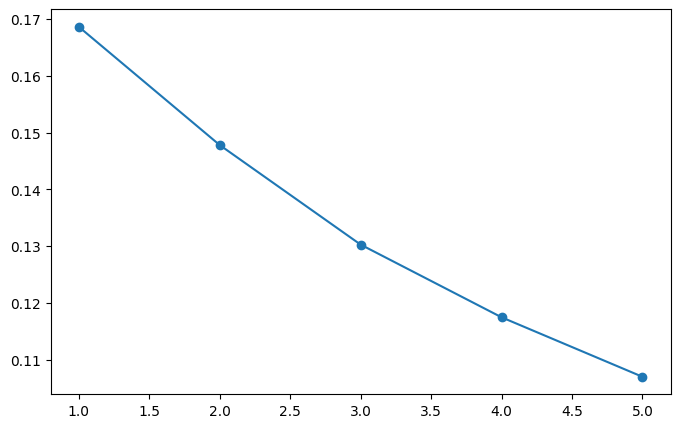

In [43]:
import matplotlib.pyplot as plt

# Plot Train and Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(metrics_df["epoch"], metrics_df["train_loss"], label="Train Loss", marker='o')
plt.plot(metrics_df["epoch"], metrics_df["val_loss"], label="Validation Loss", marker='o')
plt.title("CLIP Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Validation Accuracy (Image-to-Text & Text-to-Image)
plt.figure(figsize=(8, 5))
plt.plot(metrics_df["epoch"], metrics_df["image_to_text_acc"], label="Image→Text Accuracy", marker='o')
plt.plot(metrics_df["epoch"], metrics_df["text_to_image_acc"], label="Text→Image Accuracy", marker='o')
plt.title("CLIP Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Top-5 Accuracies
plt.figure(figsize=(8, 5))
plt.plot(metrics_df["epoch"], metrics_df["image_to_text_top5"], label="Image→Text Top-5 Acc", marker='o')
plt.plot(metrics_df["epoch"], metrics_df["text_to_image_top5"], label="Text→Image Top-5 Acc", marker='o')
plt.title("CLIP Top-5 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Top-5 Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Same dataset used for retrieval
retrieval_dataset = test_dataset

def image_collate_fn(batch):
    images = [item["image"] for item in batch]
    return processor(images=images, return_tensors="pt", padding=True)

def text_collate_fn(batch):
    texts = [item["text"] for item in batch]
    return processor(text=texts, return_tensors="pt", padding=True, truncation=True)

image_loader = DataLoader(retrieval_dataset, batch_size=32, shuffle=False, collate_fn=image_collate_fn)
text_loader = DataLoader(retrieval_dataset, batch_size=32, shuffle=False, collate_fn=text_collate_fn)


In [ ]:
import torch.nn.functional as F

def get_top_k_retrieval(model, image_loader, text_loader, k=5, device="cuda"):
    model.eval()
    all_image_embs, all_text_embs = [], []

    with torch.no_grad():
        for batch in image_loader:
            pixel_values = batch["pixel_values"].to(device)
            image_embs = model.get_image_features(pixel_values=pixel_values)
            image_embs = F.normalize(image_embs, dim=-1)
            all_image_embs.append(image_embs)

        for batch in text_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            text_embs = model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)
            text_embs = F.normalize(text_embs, dim=-1)
            all_text_embs.append(text_embs)

    all_image_embs = torch.cat(all_image_embs, dim=0)
    all_text_embs = torch.cat(all_text_embs, dim=0)

    similarity = all_image_embs @ all_text_embs.T

    topk_image_to_text = similarity.topk(k, dim=1)
    topk_text_to_image = similarity.topk(k, dim=0)

    return topk_image_to_text, topk_text_to_image


In [ ]:
# Load your best model
model.load_state_dict(torch.load("roco_clip_best_model.pt"))
model.eval().cuda()

# Compute retrieval
topk_i2t, topk_t2i = get_top_k_retrieval(model, image_loader, text_loader, k=5)


In [ ]:
def compute_recall_at_k(topk_indices, k):
    correct = 0
    for i in range(len(topk_indices)):
        if i in topk_indices[i][:k]:
            correct += 1
    return correct / len(topk_indices)


In [ ]:
recall_at_1 = compute_recall_at_k(topk_i2t.indices, 1)
recall_at_5 = compute_recall_at_k(topk_i2t.indices, 5)
print(f"Recall@1: {recall_at_1:.4f}")
print(f"Recall@5: {recall_at_5:.4f}")


In [ ]:
def compute_mrr(topk_indices):
    mrr = 0.0
    for i in range(len(topk_indices)):
        ranks = topk_indices[i].tolist()
        if i in ranks:
            rank = ranks.index(i) + 1
            mrr += 1.0 / rank
    return mrr / len(topk_indices)

mrr_score = compute_mrr(topk_i2t.indices)
print(f"MRR: {mrr_score:.4f}")


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def visualize_image_to_text(idx, hf_dataset, topk_indices):
    image = hf_dataset[idx]["image"]
    top_text_indices = topk_indices[idx].cpu().tolist()

    plt.imshow(image)
    plt.axis('off')
    plt.title("Query Image")
    plt.show()

    print("Top-5 Retrieved Captions:")
    for rank, text_idx in enumerate(top_text_indices):
        print(f"{rank+1}: {hf_dataset[text_idx]['text']}")
visualize_image_to_text(0, test_dataset, topk_i2t.indices)
